In [2]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle

# Load the enhanced dataset
df = pd.read_csv("url_dataset_enhanced.csv")

# Select features and target
features = ["url_length", "path_depth", "has_query", "has_keyword", "has_docs_subdomain",
            "code_count", "tech_keyword_count", "content_length", "has_table"]
X = df[features]
y = df["is_dev_docs"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add constant for statsmodels
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Train logistic regression model with increased iterations
model = sm.Logit(y_train, X_train_scaled)
result = model.fit(maxiter=100)  # Increased to address convergence warning

# Predict on test set
y_pred_proba = result.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Save model and scaler
with open("classifier_model.pkl", "wb") as f:
    pickle.dump(result, f)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model and scaler saved as classifier_model.pkl and scaler.pkl")

Optimization terminated successfully.
         Current function value: 0.135567
         Iterations 47
Accuracy: 0.9600
Precision: 0.9841
Recall: 0.9347
F1-Score: 0.9588
Model and scaler saved as classifier_model_content.pkl and scaler_content.pkl


In [5]:
from urllib.parse import urlparse
from bs4 import BeautifulSoup
import requests

# Load the trained model and scaler
with open("classifier_model.pkl", "rb") as f:
    model = pickle.load(f)
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# Hardcoded test URLs
test_urls = [
    "https://numpy.org/doc/stable/reference/",
    "https://www.cnn.com/world",
    "https://developer.mozilla.org/en-US/docs/Web",
    "https://www.github.com/about",
    "https://pytorch.org/docs/stable/index.html",
    "https://python.org",
    "https://docs.python.org/3/",
    "https://facebook.com/getting-started",
    "https://blog.example.com/api-tips",
    "https://docs.djangoproject.com/en/stable/",
    "https://kubernetes.io/docs/home/",
    "https://en.wikipedia.org/wiki/Main_Page",
    "https://www.youtube.com/watch?v=dQw4w9WgXcQ",
    "https://aws.amazon.com/documentation/",
    "https://learn.microsoft.com/en-us/dotnet/csharp/"
]

# Feature extraction function (must match training)
def extract_features(url):
    # URL-based features (from previous steps)
    parsed = urlparse(url)
    keywords = ["docs", "api", "reference", "sdk", "developer", "guide", "tutorial"]
    has_keyword = any(kw in url.lower() for kw in keywords)
    url_length = len(url)
    path_depth = len(parsed.path.strip('/').split('/')) if parsed.path else 0
    has_query = 1 if parsed.query else 0
    domain = parsed.netloc.lower()
    subdomain = domain.split('.')[0] if '.' in domain else domain
    has_docs_subdomain = 1 if "docs" in subdomain or "dev" in subdomain else 0

    # Content-based features
    code_count = 0
    tech_keyword_count = 0
    content_length = 0
    has_table = 0

    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")

        # Code snippet count
        code_count = len(soup.find_all(["code", "pre"]))

        # Technical keyword frequency
        tech_keywords = ["api", "endpoint", "library", "function", "class", "method", "module"]
        text = soup.get_text().lower()
        tech_keyword_count = sum(text.count(kw) for kw in tech_keywords)

        # Content length (word count)
        content_length = len(text.split())

        # Presence of tables
        has_table = 1 if soup.find("table") else 0

    except Exception as e:
        print(f"Error fetching {url}: {e}")

    return {
        "url": url,
        "url_length": url_length,
        "path_depth": path_depth,
        "has_query": has_query,
        "has_keyword": has_keyword,
        "has_docs_subdomain": has_docs_subdomain,
        "code_count": code_count,
        "tech_keyword_count": tech_keyword_count,
        "content_length": content_length,
        "has_table": has_table
    }

# Extract features for test URLs
test_features = pd.DataFrame([extract_features(url) for url in test_urls])
features = ["url_length", "path_depth", "has_query", "has_keyword", "has_docs_subdomain",
            "code_count", "tech_keyword_count", "content_length", "has_table"]
X_test = test_features[features]

# Standardize features
X_test_scaled = scaler.transform(X_test)
X_test_scaled = sm.add_constant(X_test_scaled, has_constant='add')

# Predict
probas = model.predict(X_test_scaled)
predictions = (probas > 0.5).astype(int)

# Output results
results = pd.DataFrame({
    "url": test_urls,
    "is_dev_docs_pred": predictions,
    "probability": probas
})
print("\nPredictions:")
print(results)

# Save results
results.to_csv("test_predictions.csv", index=False)
print("\nPredictions saved as test_predictions.csv")

Error fetching https://blog.example.com/api-tips: HTTPSConnectionPool(host='blog.example.com', port=443): Max retries exceeded with url: /api-tips (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7a29a59fd950>: Failed to resolve 'blog.example.com' ([Errno -2] Name or service not known)"))

Predictions:
                                                 url  is_dev_docs_pred  \
0            https://numpy.org/doc/stable/reference/                 1   
1                          https://www.cnn.com/world                 0   
2       https://developer.mozilla.org/en-US/docs/Web                 1   
3                       https://www.github.com/about                 0   
4         https://pytorch.org/docs/stable/index.html                 1   
5                                 https://python.org                 0   
6                         https://docs.python.org/3/                 1   
7               https://facebook.com/getting-started                 0   


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       201
           1       0.98      0.93      0.96       199

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



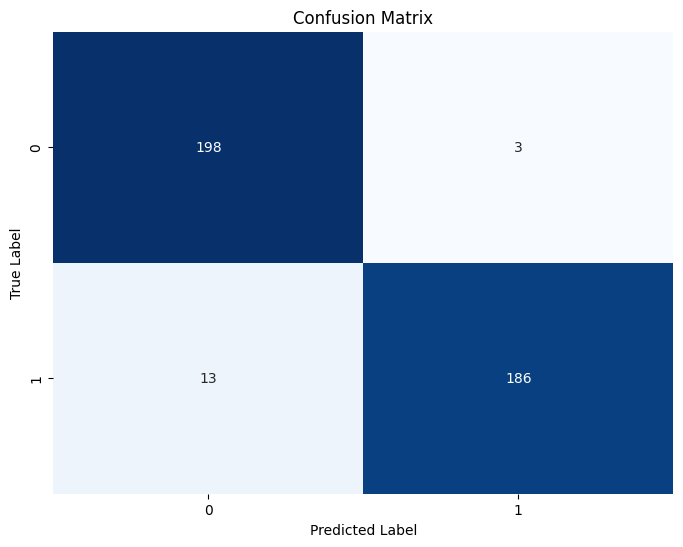

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()